# Task 3a Streaming Data Visualization

## Importing libraries

In [ ]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast

In [ ]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Climate_Hotpot_Streaming' #Topic name from the producers

#show maximum value
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
#show minimum value    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

#drow diagram
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = message.value.decode('utf-8')
            #make data into dictionary types
            dic_data = ast.literal_eval(data)
            #only do the data from producer1
            if dic_data['sender_id']=='messenger_1':
                #get the data time as x, and air temperature as y
                x.append(dic_data['time'])
                y.append(dic_data['air_temperature_celcius'])
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print('errer'+str(ex))
    
if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    

# Task 3b Static Data Visualization

## Importing libraries

In [36]:
# importing required packages 
import pandas as pd
import json
import pymongo
from pymongo import MongoClient
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import gmplot
import webbrowser

## Connection to MongoDB 

In [37]:
# Connect on the default host and port
client = MongoClient()

# getting database to connect
db = client.fit5148_assignment_db

In [38]:
#create a collection 
clim_hotspot = db.ClimateHostspot

## i) Plotting bar chart with time as x-axis and the number of fires as y-axis

In this section as advised in the lecture, we are considering the historic data from the mongoDB database and performing data visualizations. 

In [39]:
#creating a list to store all the timestamps
times = []
for rec in clim_hotspot.find(): #for every document in collection
    if rec['hotspot']==[]: 
        continue
    else: # if there is any fire incident (hotspot is not empty)
        for dic in rec['hotspot']: #for every record in hotspot
            times.append(dic['datetime'].split('T')[1]) #split the datetime to get time attribute

In [40]:
temp = Counter(times) # calculating frequency for each unique time using Counter in collections package
df = pd.DataFrame(data = temp.items()) #inserting the data into dataframe
df.columns = ['Timestamp','Count'] #naming the columns
top10 = df.sort_values(by='Count', ascending=False) #sorting the data in the Count column
top10.reset_index(inplace = True) # resetting the index of df
top10 = top10.head(10) #taking the top 10 fires

In [41]:
# printing the top 10 fires
top10

,index,Timestamp,Count
0,228,04:44:50,184
1,560,04:26:30,171
2,512,04:08:10,76
3,628,04:44:40,74
4,256,04:20:40,57
5,278,04:26:20,54
6,438,04:02:20,49
7,129,04:14:20,40
8,364,04:26:50,38
9,492,04:38:40,34


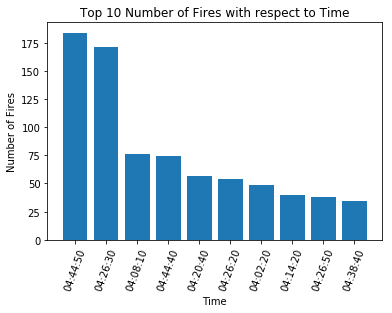

In [42]:
#plotting a bar chart using matplotlib
plt.bar(list(top10['Timestamp']),list(top10['Count']))
plt.xticks(rotation = 70)
plt.xlabel('Time')
plt.ylabel('Number of Fires')
plt.title('Top 10 Number of Fires with respect to Time')
plt.show()

## ii) Plotting fire locations on the map

In this section as advised in the lecture, we are considering the historic data from the mongoDB database and performing data visualizations. 

In [43]:
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 10) # latitude and longitude of melbourne city

In [44]:
latlong = [] #storing lat long values as a tuple for every fire
tooltips = [] #storing tooltip info for every fire
for rec in clim_hotspot.find(): #for every document in mongoDB
    if rec['hotspot']==[]:
        continue
    else: #if there is any fire data(hotspot
        for dic in rec['hotspot']: #for each record in hotspot
            latlong.append((float(dic['latitude']), float(dic['longitude']))) #append lat long values to list
            tooltips.append((dic['surface_temperature_celcius'],dic['confidence'],
                          rec['air_temperature_celcius'],rec['relative_humidity'])) #create a tooltip to display for the marker

In [45]:
# The step below is required by the gmap scatter function to prepare data in correct format
lats, longs = zip(*latlong) 

# Plotting the points on the map
for i in range(len(tooltips)):
    # create text tooltip for each marker
    text = 'Surface Temp: ' + str(tooltips[i][0]) + ' ,Confidence: ' + str(tooltips[i][1]) + ' ,Air Temp: ' + str(tooltips[i][2]) + ' ,Relative Humidity: ' + str(tooltips[i][3])
    gmap.marker(latlong[i][0], latlong[i][1], title = text) #create marker on the map

In [46]:
# Displaying the map
gmap.draw("FireLocations.html")
webbrowser.open_new("FireLocations.html")

True